<a href="https://colab.research.google.com/github/Laeti-dev/Project4-Credit-Scoring-Model/blob/master/ikusawa_laetitia_1_notebook_0824.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on [this kaggle notebook](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Read-in-Data)

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploration

There are 9 data files and 1 file explaining the variables that we'll load to understand our data.

In [ ]:
columns_descrition = pd.read_csv('/content/drive/MyDrive/OC/Projets/P4/data/HomeCredit_columns_description.csv', encoding='latin1', index_col=0)

In [ ]:
columns_descrition['Table'].unique()

array(['application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

We will work on the application_train file to start with because it contains our target.

In [ ]:
application_train = pd.read_csv('/content/drive/MyDrive/OC/Projets/P4/data/application_train.csv')

In [ ]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pd.set_option('display.max_row', None)
columns_descrition[columns_descrition['Table'] == 'application_{train|test}.csv']

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [ ]:
application_train.shape

(307511, 122)

307,511 rows where each row is a loan application and 122 columns including our target (TARGET).

Let's understain our target

In [ ]:
application_train['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


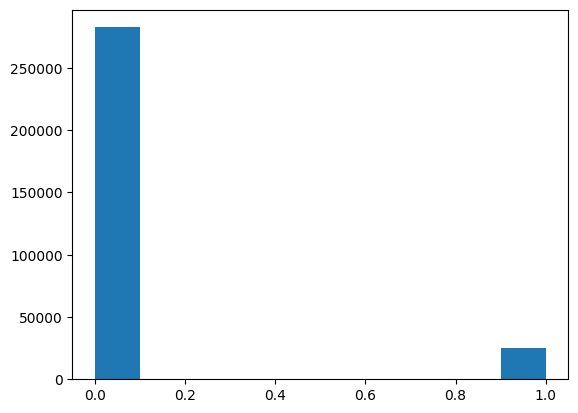

In [ ]:
fig, ax = plt.subplots()

ax.hist(application_train['TARGET'])
plt.show()